In [2]:
import parmed as pm
import networkx as nx
from pathlib import Path
import simtk.openmm.app as app
from IPython.display import SVG, display
import matplotlib.pyplot as plt


base = '../data/ce110/'
dummy_rtf = base + 'atom_definitions.rtf'
dummy_prm = base + 'parameters.prm'
psf_file_path = base + 'system_in_vac.psf'
crd_file_path = base + 'system_in_vac.crd'


In [3]:
# generate graph from psf

def _generate_graph_from_psf(psf, dummy_index = []):

    G = nx.Graph()

    normal_node_color = 'g'
    dummy_node_color = 'r'
    charge_acceptor_color = 'b'
    charge_donor_color = 'r'

    for atom in psf.atoms:

        atom_name = atom.name
        atom_index = atom.idx
        atom_type = atom.type
        atomic_number = atom.atomic_number
        node_name = str(atom_index) + '-' + str(atom_name) + '-' + str(atom_type)
        
        if atom_index in dummy_index:
            color = dummy_node_color
            atom.dummy_atom = True

        else:
            color = normal_node_color
        edge_color = color
        G.add_node(node_name, atom_name=atom_name, atom_index=atom_index, atom_type=atom_type, color=color, edge_color=edge_color, atomic_number=atomic_number)

    for bond in psf.bonds:
        a1 = bond.atom1
        a2 = bond.atom2

        atom_name_a1 = a1.name
        atom_index_a1 = a1.idx
        atom_type_a1 = a1.type
        
        node_name_a1 = str(atom_index_a1) + '-' + str(atom_name_a1) + '-' + str(atom_type_a1)
        
        atom_name_a2 = a2.name
        atom_index_a2 = a2.idx
        atom_type_a2 = a2.type

        node_name_a2 = str(atom_index_a2) + '-' + str(atom_name_a2) + '-' + str(atom_type_a2)
        
        G.add_edge(node_name_a1 , node_name_a2, atom_index_a1=atom_index_a1, atom_index_a2=atom_index_a2)

    edge_colors = []
    node_colors = []

    for node, data in G.nodes(data=True):
        edge_colors.append(data['edge_color'])
        node_colors.append(data['color'])


    return G, node_colors, edge_colors



In [4]:
# read in parameters and construct parmed system

for path in [dummy_rtf,dummy_prm,psf_file_path,crd_file_path]:
    file = Path(path)
    abs_path = file.resolve()
    
parameter_files = dummy_rtf, dummy_prm
parameter = pm.charmm.CharmmParameterSet(*parameter_files)
psf = pm.charmm.CharmmPsfFile(psf_file_path)
crd = pm.charmm.CharmmCrdFile(crd_file_path)
psf.positions = crd.positions

for a in psf.atoms:
    a.dummy_atom = False


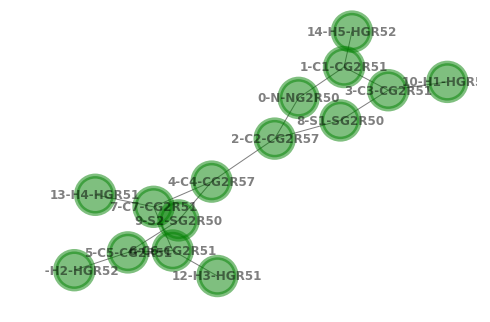

In [5]:
# draw graph

G, node_colors, edgecolors = _generate_graph_from_psf(psf)
nx.draw(G, with_labels=True, font_weight='bold', edgecolors=edgecolors, node_color=node_colors, node_size=1400, alpha=0.5, font_size=12, linewidths=5)
plt.show()

# 1a) Single terminal junction between real atoms and dummy atoms



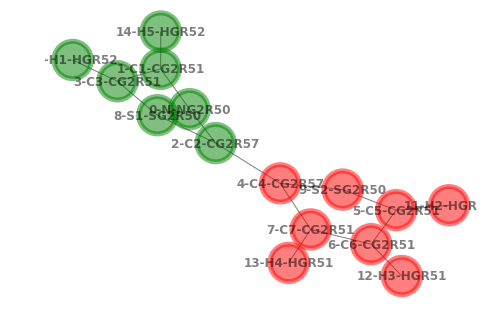

Found junction


In [12]:
# draw system
G, node_colors, edgecolors = _generate_graph_from_psf(psf, dummy_index=[4, 9, 5, 11, 6, 7, 13, 12])
nx.draw(G, with_labels=True, font_weight='bold', edgecolors=edgecolors, node_color=node_colors, node_size=1400, alpha=0.5, font_size=12, linewidths=5)
plt.show()

# set junction based on dummy_index - side note: this is only here done manually, normally this will be done automatically. 
junction = []
for bond in psf.bonds:
    if set([bond.atom1.dummy_atom, bond.atom2.dummy_atom]) == set([True, False]):
        print('Found junction')
        junction = {'dummy': bond.atom1, 'real' : bond.atom2}

In red are all the dummy atoms, in green are the real atoms.

## Dummy atom - real atom junction

The real-dummy atom junction is:
- C2 : C4[d]


## BONDS

Initially, there are two bonds defined between real and dummy atoms:

| Atom1        | Atom2           |  **DELETING** |
| :-------------: |:-------------:| :-------------:|
| C2 | C4[d] | n

bonds are not modified.

## ANGLES
Angles involving dummy atoms are between:

| Atom1        | Atom2           | Atom3           | **DELETING** |
| :-------------: |:-------------:| :-------------:| :-------------:|
| N  | C2 | C4 | 
| S1 | C2 | C4 [d] | 
| C2 | C4[d] | C7[d] | 
| C2 | C4[d] | S2[d] | 

## TORSION
Dihedrals involving dummy atoms are between:

| Atom1        | Atom2           | Atom3           | Atom4           | **DELETING** |
| :-------------: |:-------------:| :-------------:|  :-------------:| :-------------:| 
| H7 | C1 | C2[d] | O3[d] | 
| H8 | C1 | C2[d] | O3[d] | 
| H9 | C1 | C2[d] | O3[d] | 
| H7 | C1 | C2[d] | C6[d] | 
| H8 | C1 | C2[d] | C6[d] | 
| H9 | C1 | C2[d] | C6[d] | 
| C1 | C2[d] | C6[d] | H12[d] |
| C1 | C2[d] | C6[d] | C5[d] |
| C1 | C2[d] | O3[d] | C4[d] |
| C2 | C6[d] | C5[d] | H11[d] |
| C2 | C6[d] | C5[d] | C4[d] |
| C2 | O3[d] | C4[d] | H10[d] |
| C2 | O3[d] | C4[d] | C5[d] |





In [30]:
def angle_acting_on_atom(atom, angle):
    if atom in angle:
        return True
    else:
        return False

def torsion_acting_on_atom(atom, torsion):
    if atom in torsion:
        return True
    else:
        return False

def angle_acting_on_atoms(atoms, angle):
    if all(elem in angle for elem in atoms):
        return True
    else:
        return False


def torsion_acting_on_atoms(atoms, torsion):
    if all(elem in torsion for elem in atoms):
        return True
    else:
        return False


print('################')
print('List angles that act on dummy bonds:')
for idx, angle in enumerate(psf.angles):
    if junction['dummy'] in angle:
        print('Angle {}:\n {}'.format(idx, angle))
    
print('################')
print('List dihedrals that act on dummy bonds:')
for idx, dihedral in enumerate(psf.dihedrals):
    if junction['dummy'] in dihedral:
        print('Angle {}:\n {}'.format(idx, dihedral))


print('################')
print('Testing if angle/torsion acts on atom/s:')
print(angle_acting_on_atom(junction['dummy'], psf.angles[0]))
print(angle_acting_on_atoms([junction['dummy'], junction['real']], psf.angles[0]))
print(angle_acting_on_atoms([junction['dummy'], junction['real']], psf.angles[10]))


print('###############')
# If a parameter should be deleted set the following property:
psf.angles[0].marked_for_deletion = True


################
List angles that act on dummy bonds:
Angle 0:
 <Angle <Atom C1 [1]; In LIG 0>--<Atom N [0]; In LIG 0>--<Atom C2 [2]; In LIG 0>; type=None>
Angle 4:
 <Angle <Atom N [0]; In LIG 0>--<Atom C2 [2]; In LIG 0>--<Atom C4 [4]; In LIG 0>; type=None>
Angle 5:
 <Angle <Atom N [0]; In LIG 0>--<Atom C2 [2]; In LIG 0>--<Atom S1 [8]; In LIG 0>; type=None>
Angle 6:
 <Angle <Atom C4 [4]; In LIG 0>--<Atom C2 [2]; In LIG 0>--<Atom S1 [8]; In LIG 0>; type=None>
Angle 10:
 <Angle <Atom C2 [2]; In LIG 0>--<Atom C4 [4]; In LIG 0>--<Atom C7 [7]; In LIG 0>; type=None>
Angle 11:
 <Angle <Atom C2 [2]; In LIG 0>--<Atom C4 [4]; In LIG 0>--<Atom S2 [9]; In LIG 0>; type=None>
Angle 22:
 <Angle <Atom C2 [2]; In LIG 0>--<Atom S1 [8]; In LIG 0>--<Atom C3 [3]; In LIG 0>; type=None>
################
List dihedrals that act on dummy bonds:
Angle 2:
 <Dihedral; <Atom N [0]; In LIG 0>--<Atom C2 [2]; In LIG 0>--<Atom C4 [4]; In LIG 0>--<Atom C7 [7]; In LIG 0>; type=None>
Angle 3:
 <Dihedral; <Atom N [0]; In 

# RULES

There are the rules to determine what junction dummy - real atom terms are deleted:

terminal junction:
    - include all angles
    - dummy group is defined as dummy atoms with bonded terms between them
    - that's the reason why in the case of terminal junctions there will always be one big terminal group
    
- rule1: dummy bond is only allowed to act on the same real bond (per dummy group the same bond  for each dummy atom)
- rule2: 
- rule3:
